# Normalization of the count data with visualization via PCA and heatmaps

Normalization Method: TPM and log +1

Note: The heatmaps are interactable and won't load directly in Github. Open in VS Code.

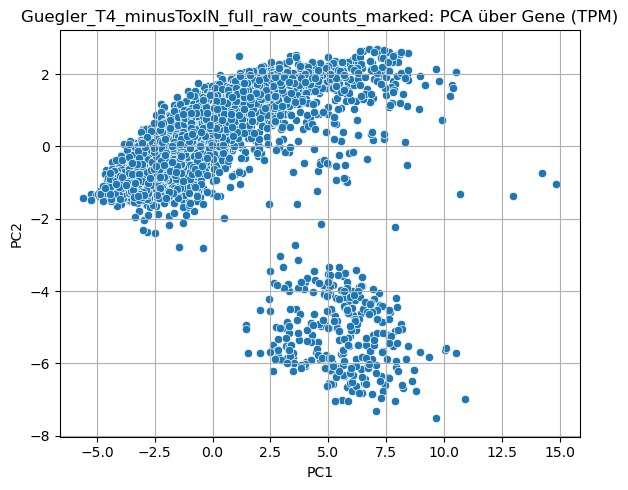

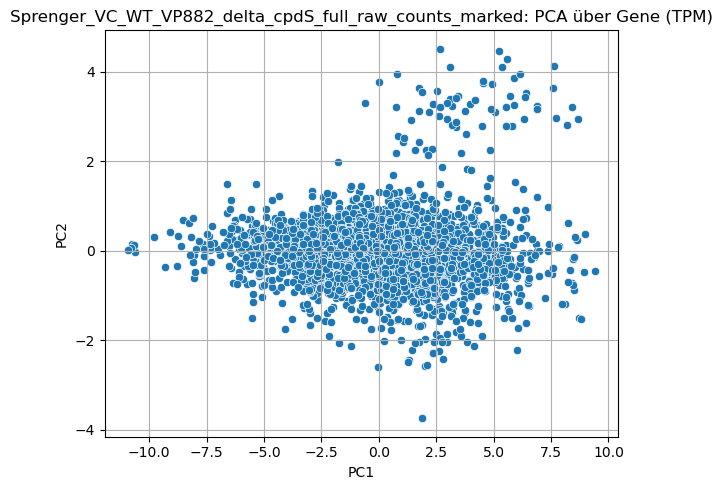

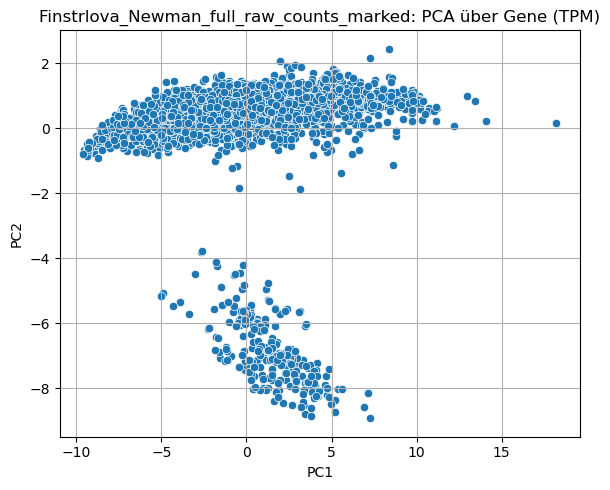

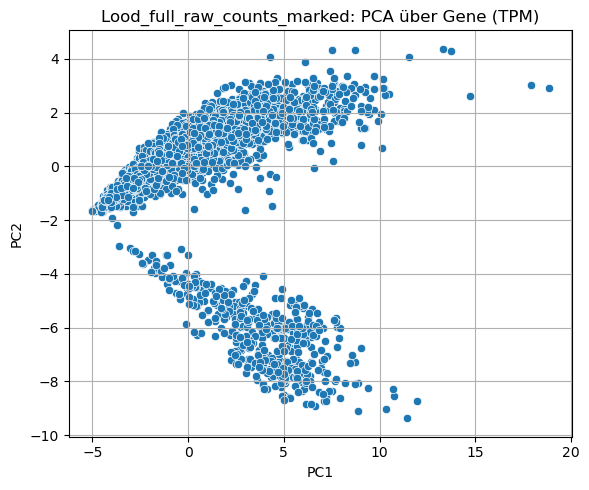

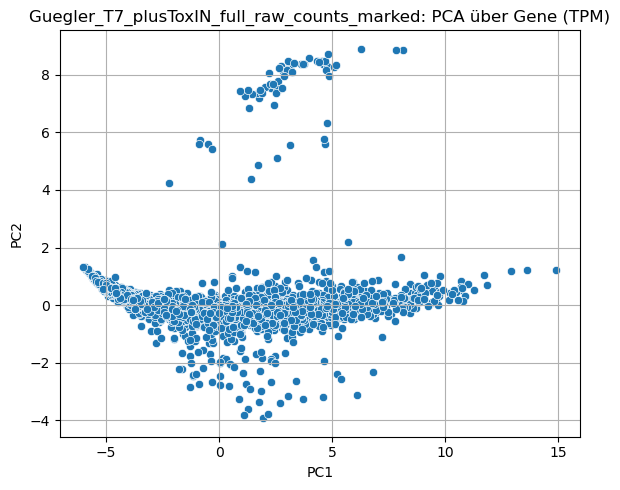

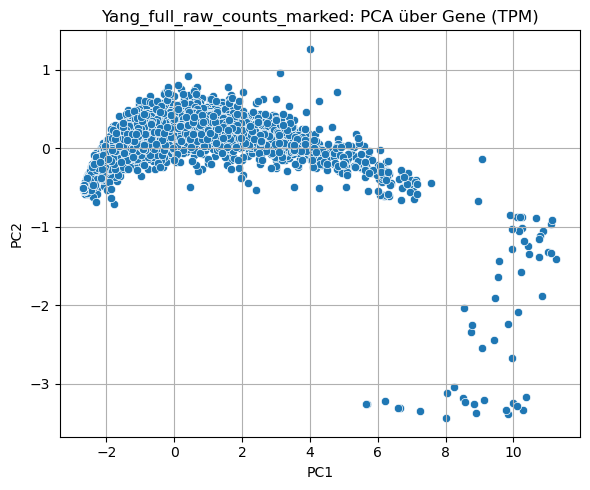

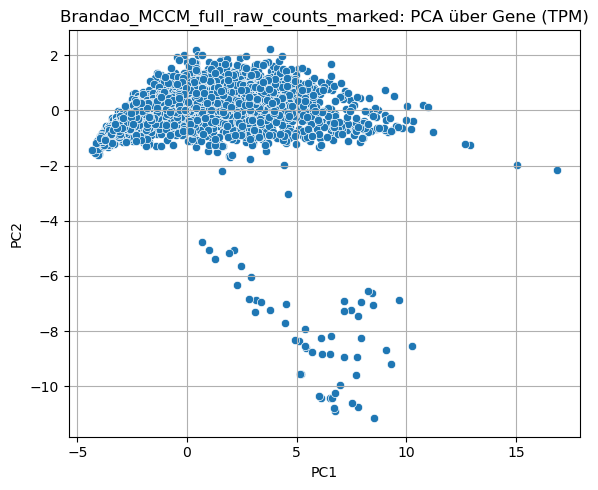

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display

# === Pfade zu den TPM-normalisierten Datensätzen ===
path_normalized = "../data/datasets_normalized"
files = [f for f in os.listdir(path_normalized) if f.endswith("_tpm.tsv")]


# === TPM-Daten laden ===
def load_tpm(path):
    df = pd.read_csv(path, sep="\t")
    df = df.set_index("Geneid")

    # Nur numerische Spalten behalten UND die letzten drei spezifisch ausschließen
    unwanted_cols = {"relative changes", "negligible changes", "Outlier"}
    df = df[
        [
            col
            for col in df.columns
            if col not in unwanted_cols and pd.api.types.is_numeric_dtype(df[col])
        ]
    ]

    return df


datasets = {}
for file in files:
    dataset_name = file.replace("_tpm.tsv", "")
    datasets[dataset_name] = load_tpm(os.path.join(path_normalized, file))


# === Heatmap-Funktion ===
def interactive_heatmap(tpm_df, title, method="sum"):
    # TPM-Werte log2-transformieren
    tpm_log = np.log2(tpm_df + 1)

    # Scoring-Funktion
    if method == "sum":
        gene_scores = tpm_log.sum(axis=1)
    elif method == "variance":
        gene_scores = tpm_log.var(axis=1)
    else:
        raise ValueError("Methode muss 'sum' oder 'variance' sein.")

    total_genes = len(gene_scores)

    # Slider definieren
    slider = widgets.IntSlider(
        value=20,
        min=1,
        max=100,
        step=1,
        description="Top % Gene:",
        continuous_update=False,
        layout=widgets.Layout(width="400px"),
    )

    # Callback-Funktion
    def update_heatmap(top_percent):
        top_n = max(1, int((top_percent / 100) * total_genes))
        top_genes = gene_scores.sort_values(ascending=False).head(top_n).index
        data = tpm_log.loc[top_genes]

        plt.figure(figsize=(10, 10))
        sns.heatmap(
            data,
            cmap="coolwarm",
            vmin=0,
            vmax=10,
            center=5,
            yticklabels=False,
            xticklabels=True,
            cbar_kws={"label": "Log2(TPM + 1)"},
        )
        plt.title(f"{title} – Top {top_percent}% Gene")
        plt.xlabel("Samples")
        plt.ylabel("Top variable Genes")
        plt.tight_layout()
        plt.show()

    widgets.interact(update_heatmap, top_percent=slider)


# === PCA-Plot Funktion ===
def plot_pca_genes(tpm_df, title):
    data = np.log2(tpm_df + 1)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data)

    pca = PCA(n_components=2)
    components = pca.fit_transform(scaled)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=components[:, 0], y=components[:, 1])
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# === Visualisierung aller geladenen Datensätze ===
for name, df in datasets.items():
    plot_pca_genes(df, f"{name}: PCA über Gene (TPM)")

    interactive_heatmap(df, f"{name}: Log2-TPM Heatmap")


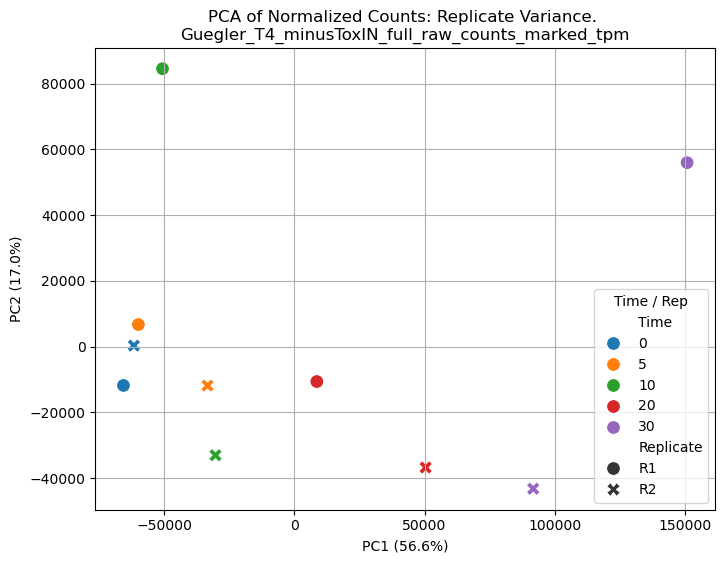

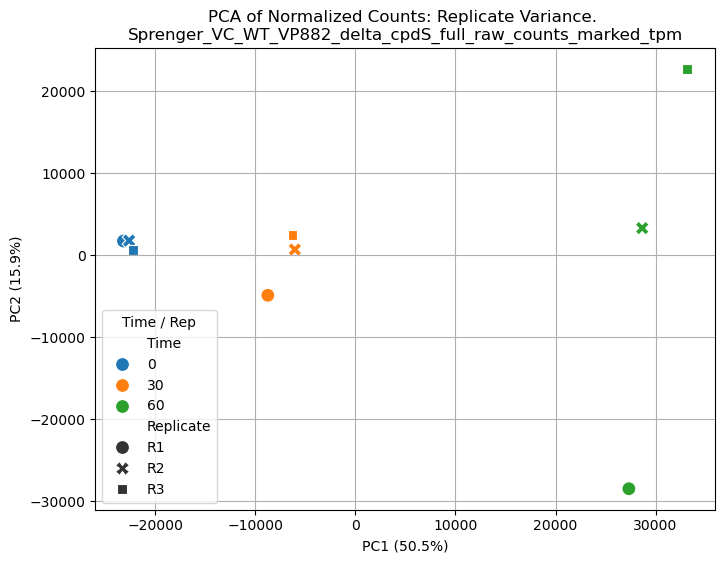

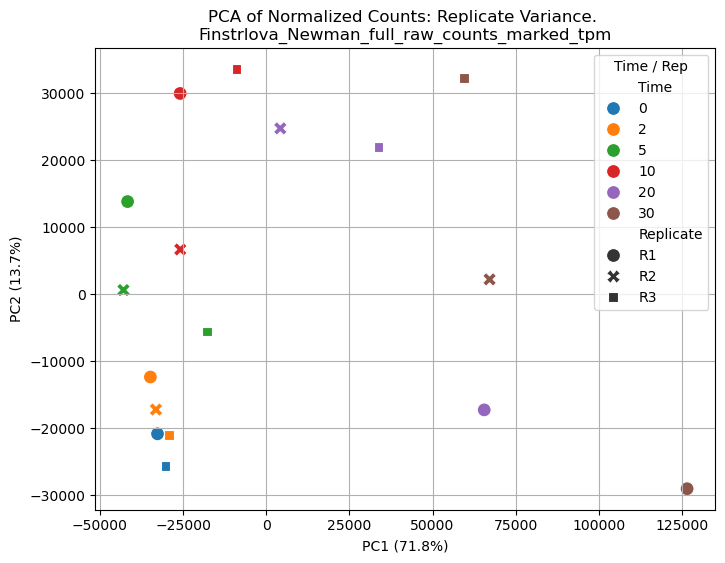

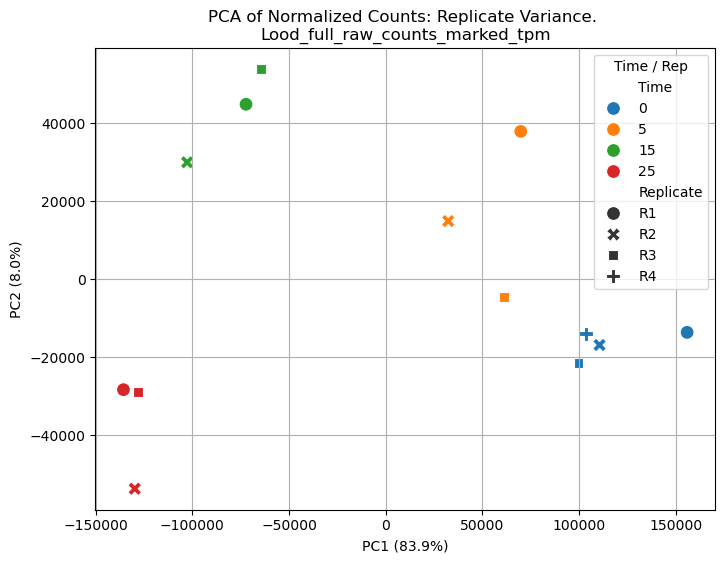

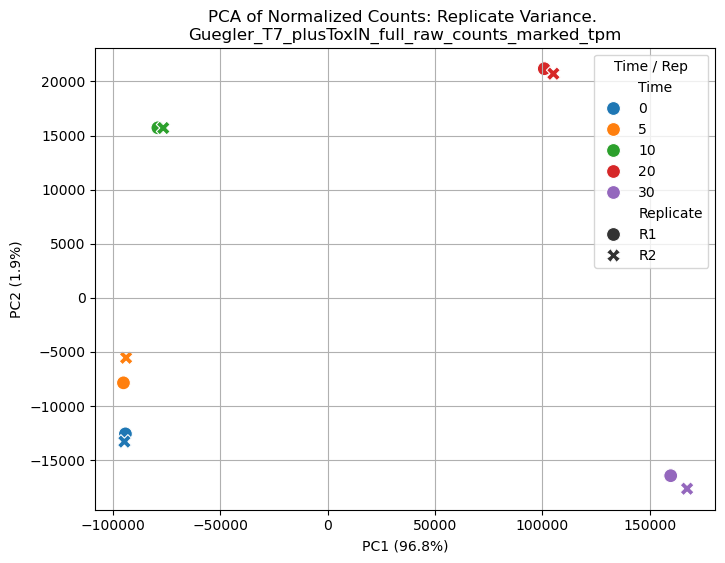

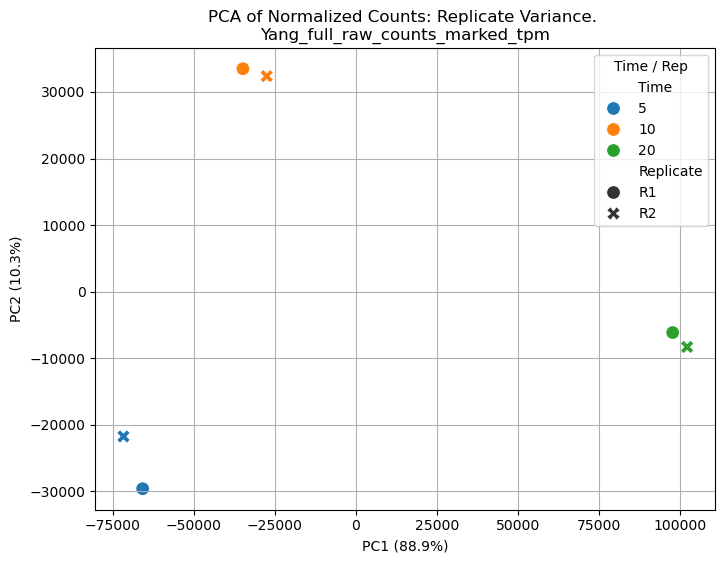

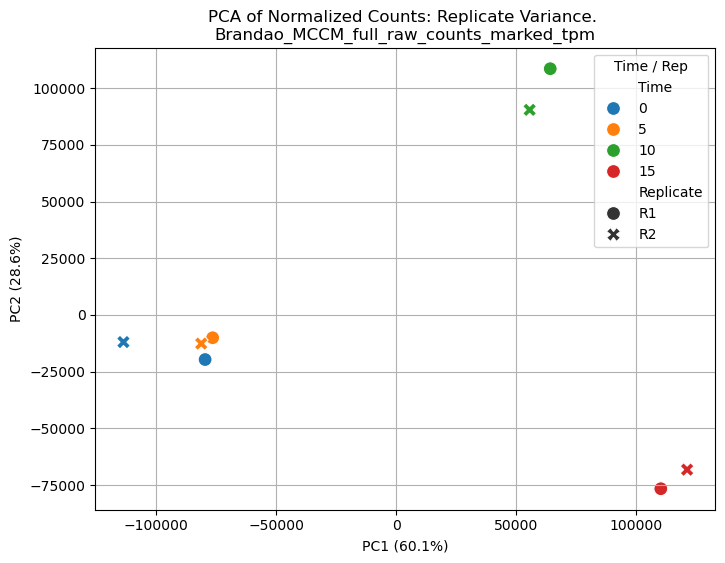

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import seaborn as sns
from pathlib import Path


def run_pca(df, set_name):
    # Get samples and drop the rest of the columns
    sample_cols = [col for col in df.columns if re.match(r"^\d+_R\d+$", col)]
    data = df[sample_cols]

    # print(data)

    # Transpose so samples are rows
    data_T = data.transpose()
    data_T.columns = df["Geneid"]  # Assign gene names as column headers
    data_T.index.name = "Sample"

    # Reset index to extract time point and replicate info
    data_T = data_T.reset_index()

    # Extract time and replicate into new columns
    data_T["Time"] = data_T["Sample"].apply(lambda x: x.split("_")[0])
    data_T["Replicate"] = data_T["Sample"].apply(lambda x: x.split("_")[1])

    # print(data_T)

    # Drop sample name and metadata
    features = data_T.drop(columns=["Sample", "Time", "Replicate"])

    # print(features)

    # Run PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    # Add PCA results to DataFrame
    data_T["PC1"] = pca_result[:, 0]
    data_T["PC2"] = pca_result[:, 1]

    # Plot PCA
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=data_T,
        x="PC1",
        y="PC2",
        hue="Time",
        style="Replicate",
        s=100,
        palette="tab10",
    )
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
    plt.title(f"PCA of Normalized Counts: Replicate Variance. \n{set_name}")
    plt.legend(title="Time / Rep")
    plt.grid(True)
    plt.show()


input_folder = Path("../data/datasets_normalized")
for ds in input_folder.glob("*.tsv"):
    df = pd.read_csv(ds, sep="\t")
    set_name = ds.stem
    run_pca(df, set_name)
